<a href="https://colab.research.google.com/github/Christelleelkhoury/AI-for-Med.Diagnos.-Prediction/blob/main/Week5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - AI for Medical Diagnosis and Prediction | Week #5

In this notebook, we continue our analysis of the MIMIC-CXR dataset by analyzing the performance of the CNN trained during the previous week, and especially exploring potential sources of unfairness and biases. The objective is to perform an analysis of the model and implement a strategy that could mitigate unfairness.  

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Load the dataset using the same train, validation and test splits as during the previous week <i>(Task 1)</i> <br>
- Observe the training set and the different population subgroups <i>(Task 1*)</i> <br>
- Load the pretrained convolutional neural network <i>(Task 2)</i> <br>
- Evaluate and compare the performance of the models using appropriate metrics across subgroups <i>(Task 2*)</i> <br>
- Implement a strategy to mitigate unfairness: oversampling or data augmentation <i>(Task 3)</i> <br>
- Re-evaluate the performance of the newly trained model regarding fairness and biases <i>(Task 4)</i>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

!pip install pydicom grad-cam -q
!python3.8 -m pip install opencv-python
import pydicom
import time
import cv2
from PIL import Image
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import tv_tensors
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/bin/bash: line 1: python3.8: command not found


In [ ]:
DATA_PATH = './MIMIC-CXR'

If you do not have the dataset anymore, please re-run the following cell to download it. Here, we will use the chest X-ray images and the labels extracted.

In [ ]:
!wget https://uni-bonn.sciebo.de/s/KrMiTk2X7sgBCwK/download/MIMIC-CXR-png.zip -O MIMIC-CXR-png.zip
!unzip MIMIC-CXR-png.zip -d ./

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ./MIMIC-CXR-png/segmentation/18061783/52119829/c3f7e5ef-b37abc31-841e861f-3773f7c6-cd79e0e0.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/52109079/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/52109079/f8532a91-2d34769b-7afcc3c2-132b6010-90eafdf3.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/53017596/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/53017596/fe88afe0-5db46aac-9b35164c-00001574-cbe3dd88.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/58867787/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/58867787/aafdfb59-2ef9d4e1-795db55d-41504c44-0e961995.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/51783178/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/51783178/e113e4a8-b00775ef-3373de4d-c3cc3ef4-7b51e532.png  
   creating: ./MIMIC-CXR-png/segmentation/18061783/54160003/
  inflating: ./MIMIC-CXR-png/segmentation/18061783/54160003/fd92923e-6d3b

In [ ]:
!wget https://uni-bonn.sciebo.de/s/r7iYfS2QTDrA4CD/download/labels.csv -O labels.csv
!wget https://uni-bonn.sciebo.de/s/tjc7eF5CsynKwrG/download/train_labels.csv -O train_labels.csv
!wget https://uni-bonn.sciebo.de/s/KFyAPTgjqMPWiBA/download/test_labels.csv -O test_labels.csv
!wget https://uni-bonn.sciebo.de/s/f7yaDakFNS5C2n7/download/metadata_clean.csv - O metadata_clean.csv

--2025-09-15 13:19:43--  https://uni-bonn.sciebo.de/s/f7yaDakFNS5C2n7/download/metadata_clean.csv
Resolving uni-bonn.sciebo.de (uni-bonn.sciebo.de)... 128.176.1.2
Connecting to uni-bonn.sciebo.de (uni-bonn.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198371 (194K) [text/csv]
Saving to: ‘metadata_clean.csv’

metadata_clean.csv  100%[===================>] 193.72K   323KB/s    in 0.6s    

2025-09-15 13:19:45 (323 KB/s) - ‘metadata_clean.csv’ saved [198371/198371]

--2025-09-15 13:19:45--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2025-09-15 13:19:45--  http://o/
Resolving o (o)... failed: Name or service not known.
wget: unable to resolve host address ‘o’
--2025-09-15 13:19:45--  http://metadata_clean.csv/
Resolving metadata_clean.csv (metadata_clean.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘metadata_clean.csv’
FINISHED --2025-09-15 1

In [ ]:
metadata_df = pd.read_csv('metadata_clean.csv')

In [ ]:
metadata_df.head(5)

,Unnamed: 0,subject_id,study_id,dicom_id,dicom_path,report_path,mask_path,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning
0,0,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,files/p18/p18000291/s55388853/04564240-d4e9e69...,files/p18/p18000291/s55388853.txt,segmentation/18000291/55388853/04564240-d4e9e6...,CHEST (PA AND LAT),postero-anterior
1,1,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,files/p18/p18000291/s55388853/ed82a88d-499bed8...,files/p18/p18000291/s55388853.txt,segmentation/18000291/55388853/ed82a88d-499bed...,CHEST (PA AND LAT),postero-anterior
2,2,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...,files/p18/p18000379/s51062789.txt,segmentation/18000379/51062789/eac2b8fa-9245fe...,CHEST (PA AND LAT),postero-anterior
3,3,18000379,51568340,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,files/p18/p18000379/s51568340/3631ff3b-cfcb244...,files/p18/p18000379/s51568340.txt,segmentation/18000379/51568340/3631ff3b-cfcb24...,CHEST (PORTABLE AP),antero-posterior
4,4,18000379,51817182,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,files/p18/p18000379/s51817182/f6f04111-c3fde25...,files/p18/p18000379/s51817182.txt,segmentation/18000379/51817182/f6f04111-c3fde2...,CHEST (PORTABLE AP),antero-posterior


Retrieve the splits

In [ ]:
labels_df = pd.read_csv('labels.csv')
test_df = pd.read_csv('test_labels.csv')
train_df = pd.read_csv('train_labels.csv')
patient_train = train_df['subject_id'].unique()

patient_train, patient_val = train_test_split(
    patient_train, # List or array to split
    test_size=0.2, # Size of the subset
    random_state=42)

train_df = labels_df.loc[labels_df['subject_id'].isin(patient_train)]
val_df = labels_df.loc[labels_df['subject_id'].isin(patient_val)]
df = pd.concat([train_df, val_df, test_df])

In [ ]:
train_df

,labels_encoded,pathology,subject_id,study_id,dicom_id
14,[1 0 0 0 0 0 0 0 0 0 0 1 1 0],1,18000570,51014962,1843fb57-c53b5ad7-de39ad5a-3701dd61-91114279
18,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18001760,51437059,c6a164b9-a805e3e2-c72898e9-24cf798d-58c6ee13
19,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18001760,53945737,7cdde258-219ed068-d374517a-e4629637-8ea5624f
20,[0 0 1 0 0 0 0 0 0 0 0 0 0 0],1,18001760,54266866,a48cc3d6-7f2457e2-58e27345-3b464ec2-7c3d529c
21,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18001760,54347965,a5a1acb7-3c96a449-45b2761b-6190a646-ecaa3786
...,...,...,...,...,...
655,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18668479,52393200,b188930b-cc78e4a3-cd76c68c-d890a5b8-1d5b1f08
656,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18668479,52393200,d22f5b56-f551a0a1-27b53706-d3e812dc-fbe550ae
666,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18888500,51729438,e2408806-a140db62-8e4d4627-766f70d1-b18c7f0b
667,[1 0 0 1 0 0 0 0 0 0 0 0 0 0],1,18984616,55967331,5a77c3a2-d0f94e09-94eb621f-f66d487c-947ee67c


## Task 1 - Dataset exploration

* Explore the different demographics available in the dataset and count the number of samples in each subgroup
* Plot a few statistics about the composition of the train set, and reflect on the potential impact on fairness

As we have realized before, this dataset as been previously annonymized, so useful attributes for fairness like the sex, age, etnicity are not available to us. This is a good practice and its often the case with public datasets.
Nevertheless, we can explore and still derive useful attributes that can be used for fairness and bias



In [ ]:
#@title helper

df = metadata_df.copy()

# Projection from ViewCodeSequence_CodeMeaning
def map_projection(s):
    if pd.isna(s): return np.nan
    s = s.strip().lower()
    if 'postero' in s and 'anterior' in s:  # "postero-anterior"
        return 'PA'
    if 'antero' in s and 'posterior' in s:  # "antero-posterior"
        return 'AP'
    if 'lateral' in s:
        return 'LAT'
    return 'OTHER'

df['projection'] = df['ViewCodeSequence_CodeMeaning'].map(map_projection)

# Portable flag from ProcedureCodeSequence_CodeMeaning
df['is_portable'] = df['ProcedureCodeSequence_CodeMeaning'] \
    .str.contains('portable', case=False, na=False)

# Lateral ordered flag from ProcedureCodeSequence_CodeMeaning
df['has_lateral'] = df['ProcedureCodeSequence_CodeMeaning'] \
    .str.contains('lat', case=False, na=False)

# Combined slice
df['projection_portable'] = df['projection'].fillna('UNK') + '_' + df['is_portable'].map({True:'PORT', False:'NONPORT'})

# Procedure family
df['procedure_family'] = df['ProcedureCodeSequence_CodeMeaning'] \
    .str.extract(r'^\s*([A-Z ]+)\s*\(', expand=False) \
    .str.strip().fillna('UNK')

# df[['dicom_id','projection','is_portable','has_lateral','projection_portable','procedure_family']]


In [ ]:
for col in ['projection','is_portable','has_lateral','projection_portable','procedure_family']:
    display(df[col].value_counts())

,count
projection,
AP,413
PA,256


,count
is_portable,
True,346
False,323


,count
has_lateral,
False,350
True,319


,count
projection_portable,
AP_PORT,346
PA_NONPORT,256
AP_NONPORT,67


,count
procedure_family,
CHEST,668
UNK,1


- Projection: PA vs AP (from ViewCodeSequence_CodeMeaning, e.g., “postero-anterior” / “antero-posterior”).

- Portable: True if ProcedureCodeSequence_CodeMeaning contains “PORTABLE”.

- Has_Lateral: True if ProcedureCodeSequence_CodeMeaning contains “LAT” (proxy for multi‑view exam).

- Projection × Portable: combined slice to check interaction (e.g., AP‑portable vs PA‑non‑portable).

While attributes like gender and ethnicity are direct protected attributes, the metadata we've listed can be used as proxy attributes. They don't describe who the patient is, but they describe the circumstances of their medical care, which can be strongly correlated with factors like health severity, access to care, and socioeconomic status.

If many fields are constant in your subset (e.g., all CHEST, all PA), they won’t help—focus on those that vary across your cohort (view position, orientation, exposure indices, KVP, pixel spacing/resolution, care setting, and time).



First we wil match our newly attributes with the splits we trained our data on

In [ ]:
#@title helper matching

ATTR_COLS = [
    'projection', 'is_portable', 'has_lateral',
    'projection_portable', 'procedure_family',
    'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning'
]

meta_attrs = (df[['subject_id','study_id','dicom_id'] + ATTR_COLS]
              .drop_duplicates(subset=['subject_id','study_id','dicom_id'])
              .copy())

for col in ['is_portable','has_lateral']:
    if col in meta_attrs:
        meta_attrs[col] = meta_attrs[col].astype('boolean')

for col in ['projection','projection_portable','procedure_family',
            'ProcedureCodeSequence_CodeMeaning','ViewCodeSequence_CodeMeaning']:
    if col in meta_attrs:
        meta_attrs[col] = meta_attrs[col].astype('category')

def attach_attrs(split_df, attrs=meta_attrs):
    keys = ['subject_id','study_id','dicom_id']
    assert attrs.duplicated(keys).sum() == 0, "meta_attrs has duplicate keys"
    out = split_df.merge(attrs, on=keys, how='left', validate='m:1', indicator=True)
    miss = (out['_merge'] == 'left_only').sum()
    if miss:
        print(f"[WARN] {miss} rows in split had no match in meta_attrs. "
              f"Examples:\n{out.loc[out['_merge']=='left_only', keys].head(5)}")
    return out.drop(columns=['_merge'])

train_df = attach_attrs(train_df)
val_df   = attach_attrs(val_df)
test_df  = attach_attrs(test_df)

for name, d in [('train', train_df), ('val', val_df), ('test', test_df)]:
    tot = len(d)
    na_proj = d['projection'].isna().sum()
    print(f"{name}: rows={tot}, projection missing={na_proj} ({na_proj/tot:.1%})")

# Construct the full expected PNG path for each row
image_dir = './MIMIC-CXR-png/files-png'
train_df['img_path'] = train_df.apply(lambda r: os.path.join(image_dir,f"p{r.subject_id}",f"s{r.study_id}",f"{r.dicom_id}.png"),axis=1);train_df.reset_index(drop=True,inplace=True)
val_df['img_path'] = val_df.apply(lambda r: os.path.join(image_dir,f"p{r.subject_id}",f"s{r.study_id}",f"{r.dicom_id}.png"),axis=1);val_df.reset_index(drop=True, inplace=True)
test_df['img_path'] = test_df.apply(lambda r: os.path.join(image_dir,f"p{r.subject_id}",f"s{r.study_id}",f"{r.dicom_id}.png"),axis=1);test_df.reset_index(drop=True,inplace=True)

# Function to check existence and drop missing images
def check_and_drop_missing_images(df, name):
    exists_mask = df['img_path'].map(os.path.exists)
    if not exists_mask.all():
        missing_count = (~exists_mask).sum()
        print(f"Dropping {missing_count} missing images from {name}:")
        for p in df.loc[~exists_mask, 'img_path'].head(5):
            print("    ", p)
        df = df[exists_mask].reset_index(drop=True)
    else:
        print(f"All images in {name} exist.")
    return df

# Apply the function to train_df, val_df, and test_df
train_df = check_and_drop_missing_images(train_df, "train_df")
val_df = check_and_drop_missing_images(val_df, "val_df")
test_df = check_and_drop_missing_images(test_df, "test_df")

[WARN] 2 rows in split had no match in meta_attrs. Examples:
     subject_id  study_id                                      dicom_id
198    18203000  57706573  8ca2e09a-71230b80-d70b530a-4d43b9bd-6f946a83
207    18609163  55780808  bb39daf0-880b7aff-4f7ded43-69ac6f07-465053db
train: rows=268, projection missing=0 (0.0%)
val: rows=46, projection missing=0 (0.0%)
test: rows=231, projection missing=2 (0.9%)
All images in train_df exist.
All images in val_df exist.
Dropping 2 missing images from test_df:
     ./MIMIC-CXR-png/files-png/p18203000/s57706573/8ca2e09a-71230b80-d70b530a-4d43b9bd-6f946a83.png
     ./MIMIC-CXR-png/files-png/p18609163/s55780808/bb39daf0-880b7aff-4f7ded43-69ac6f07-465053db.png


In [ ]:
train_df.head()

,labels_encoded,pathology,subject_id,study_id,dicom_id,projection,is_portable,has_lateral,projection_portable,procedure_family,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,img_path
0,[1 0 0 0 0 0 0 0 0 0 0 1 1 0],1,18000570,51014962,1843fb57-c53b5ad7-de39ad5a-3701dd61-91114279,PA,False,True,PA_NONPORT,CHEST,CHEST (PA AND LAT),postero-anterior,./MIMIC-CXR-png/files-png/p18000570/s51014962/...
1,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18001760,51437059,c6a164b9-a805e3e2-c72898e9-24cf798d-58c6ee13,PA,False,True,PA_NONPORT,CHEST,CHEST (PA AND LAT),postero-anterior,./MIMIC-CXR-png/files-png/p18001760/s51437059/...
2,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18001760,53945737,7cdde258-219ed068-d374517a-e4629637-8ea5624f,PA,False,True,PA_NONPORT,CHEST,CHEST (PA AND LAT),postero-anterior,./MIMIC-CXR-png/files-png/p18001760/s53945737/...
3,[0 0 1 0 0 0 0 0 0 0 0 0 0 0],1,18001760,54266866,a48cc3d6-7f2457e2-58e27345-3b464ec2-7c3d529c,PA,False,True,PA_NONPORT,CHEST,CHEST (PA AND LAT),postero-anterior,./MIMIC-CXR-png/files-png/p18001760/s54266866/...
4,[0 0 0 0 0 0 0 0 0 1 0 0 0 0],0,18001760,54347965,a5a1acb7-3c96a449-45b2761b-6190a646-ecaa3786,PA,False,True,PA_NONPORT,CHEST,CHEST (PA AND LAT),postero-anterior,./MIMIC-CXR-png/files-png/p18001760/s54347965/...


## Subgroup analysis and definitions

Q1. Reflection and Analysis of Bias:

Do the plots reveal a clear imbalance in our training data based on these clinical proxies?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Training Set Distribution ---")

# Analyze the 'projection' attribute in the training data
print("\nProjection Distribution in train_df:")
projection_counts = train_df['projection'].value_counts()
print(projection_counts)

# 2. Analyze the 'is_portable' attribute in the training data
print("\n------------------------------------")
print("Portability Distribution in train_df:")
portable_counts = train_df['is_portable'].value_counts()
print(portable_counts)

--- Training Set Distribution ---

Projection Distribution in train_df:
projection
AP    154
PA    114
Name: count, dtype: int64

------------------------------------
Portability Distribution in train_df:
is_portable
False    141
True     127
Name: count, dtype: Int64


Visualize the distributions, pass the `.index` and `.values` of your count

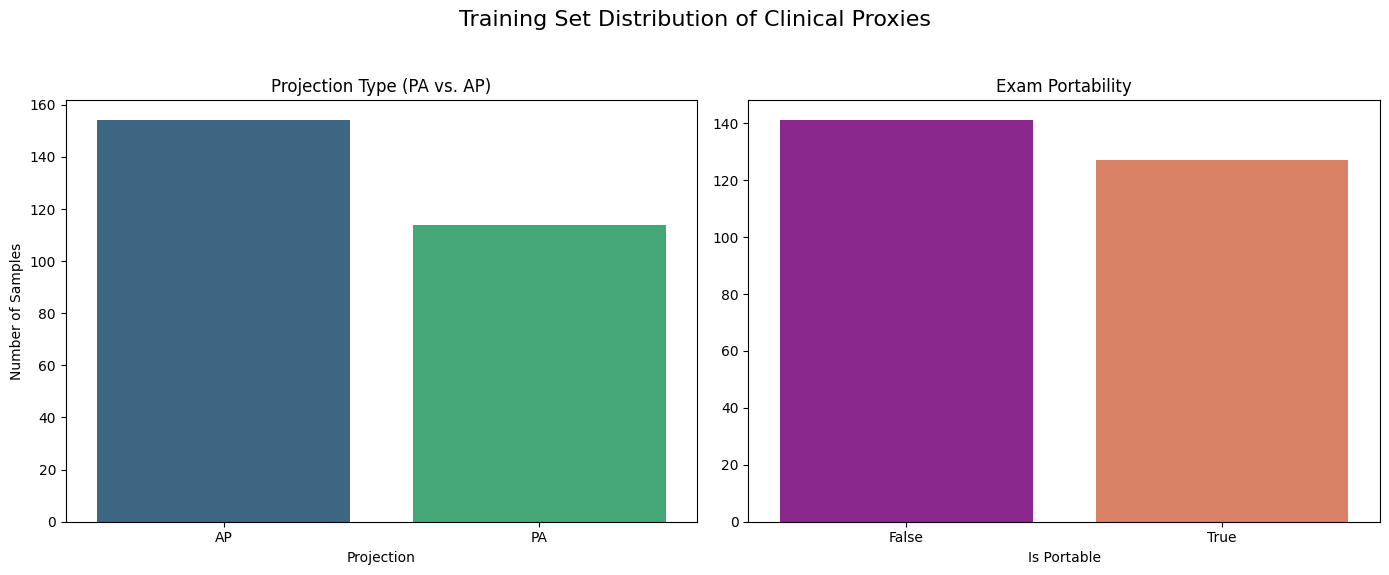

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Training Set Distribution of Clinical Proxies', fontsize=16)

# Plot for Projection
sns.barplot(x=projection_counts.index, y=projection_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title('Projection Type (PA vs. AP)')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xlabel('Projection')

# Plot for Portability
sns.barplot(x=portable_counts.index, y=portable_counts.values, ax=axes[1], palette="plasma")
axes[1].set_title('Exam Portability')
axes[1].set_ylabel('') # Hide y-label to avoid repetition
axes[1].set_xlabel('Is Portable')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Why they can be use as fairness proxies:**
- `projection and is_portable` (postero-anterior) is the gold standard view for a chest X-ray. It requires the patient to be **stable and able to stand**. AP (antero-posterior) views are often taken with a portable machine at the patient's bedside because they are too sick or immobile to go to the radiology department (e.g., they are in the ICU).

- A model that performs worse on `AP or portable scans` is failing more often on the sickest, most vulnerable patients. This is a major fairness and safety concern. If your model helps find a pathology in healthy outpatients but fails for ICU patients, it has a critical flaw.

- Therefore, these field is a strong proxies for patient acuity (how sick the patient is).

Moderately Useful: `has_lateral`

- What it means: A standard chest exam often includes two views: a PA and a Lateral. A single-view exam might be ordered for a quick follow-up or in an emergency where time is critical.
- This is a weaker proxy, but it could represent different clinical protocols or settings. For example, a resource-strapped clinic might be more likely to order single-view exams. A model that performs poorly on single-view exams might be biased against patient populations served by such clinics.

Not Useful: `procedure_family`
- This shows that almost every exam was a CHEST X-ray. The distribution is too skewed. The single UNK (unknown) case is likely a data entry error and provides no signal for a fairness analysis.


### Analysis of Disease Prevalence Across Subgroups

Now it is crucial to analyze the prevalence; As if the model sees that a certain group has a much higher rate of disease, it might learn to be biased and over-predict the positive class for any member of that group, regardless of the actual image features


--- Disease Prevalence (Positive Rate) by Clinical Subgroup ---
is_portable     False     True 
projection                     
AP           0.407407  0.637795
PA           0.429825       NaN


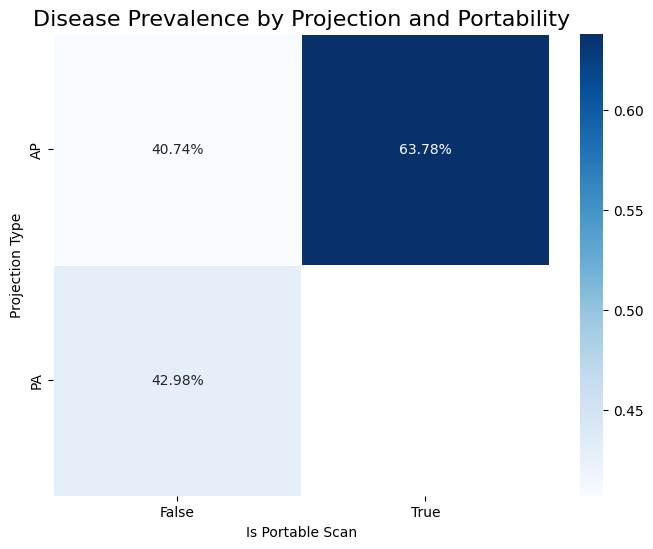

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

prevalence_by_group = train_df.groupby(['projection', 'is_portable'])['pathology'].mean()

# To make this easier to read and plot, we can unstack it into a pivot table format
prevalence_pivot = prevalence_by_group.unstack()

print("--- Disease Prevalence (Positive Rate) by Clinical Subgroup ---")
print(prevalence_pivot)

# Visualize the prevalence as a heatmap
plt.figure(figsize=(8, 6))

# fmt='.2%' formats the numbers as percentages with two decimal places
sns.heatmap(prevalence_pivot, annot=True, fmt='.2%', cmap=plt.cm.Blues, linewidths=.5)

plt.title('Disease Prevalence by Projection and Portability', fontsize=16)
plt.xlabel('Is Portable Scan')
plt.ylabel('Projection Type')
plt.show()

 What correlations are revealed by the heatmap, what potential sources of bias could be there for a lazy model (model that learn weak pattenrs, i.e. a recurrent mark on the X-ray instead of the pathology, etc.)?

## Task 2 - Performance across subgroups

* Compute the performance of the classifier trained during week 4 on each subgroup individually
* Compare these performance across subgroups, and look for any unfavored subgroups
* Reflect and comment on the link between the performance and the composition of the train dataset

In [ ]:
#@title Helpers
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from PIL import ImageOps
class ClassificationDataset(Dataset):
    def __init__(self, dataframe, image_dir=None, train=False, image_size=380, channels=3):
        super().__init__()
        # assume dataframe has already been filtered and contains 'img_path' and 'pathology'
        self.image_paths = dataframe['img_path'].tolist()
        self.labels      = dataframe['pathology'].tolist()
        self.size        = image_size
        if channels== 3:
          self.mean = np.array([0.485, 0.456, 0.406])
          self.std  = np.array([0.229, 0.224, 0.225])
        elif channels==1:
          self.mean = np.array([0.5])
          self.std  = np.array([0.2])

      #  # build transforms
        if train:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.RandomRotation(degrees=(-20, 20)),
                torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
                torchvision.transforms.RandomResizedCrop(self.size, scale=(0.4, 0.6),ratio=(1.0, 1.0)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std),
            ])
        else:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.Resize((512, 512)),
                torchvision.transforms.CenterCrop((self.size, self.size)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std)
            ])

    def __getitem__(self, index: int):
        path   = self.image_paths[index]
        image  = Image.open(path).convert('L')
        image = self.transforms_img(image)
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)

train_dataset_cls = ClassificationDataset(
    train_df,
    f'{DATA_PATH}/files-png/',
    train = True
)

val_dataset_cls = ClassificationDataset(
    val_df,
    f'{DATA_PATH}/files-png/'
)

def train_loop_cls(dataloader, model, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # Compute prediction and loss
        logits = model(X)
        loss = loss_fn(logits, y)
        # Backpropagation
        loss.backward()
        optimizer.step()

        # accumulate
        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == y).sum().item()
        running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f"Train → Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    # return model, epoch_loss, epoch_acc
    return model


def val_loop_cls(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == y).sum().item()
            running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f" Val  → Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}\n")
    # return epoch_loss, epoch_acc
    return epoch_acc

Download/Load the model

In [ ]:
!curl https://uni-bonn.sciebo.de/s/kqBeRJs9yz85AEA/download/efficientnetb4-pathology-cxr2.pth --output efficientnetb4-pathology-cxr2.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.6M  100 67.6M    0     0  10.8M      0  0:00:06  0:00:06 --:--:-- 16.3M


In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

model_cls = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
model_cls.classifier[1] = nn.Sequential(
    nn.Linear(1792, 2)
)

model_cls.load_state_dict(torch.load('./efficientnetb4-pathology-cxr2.pth'))
print("Loaded state dictionary from 'efficientnetb4-pathology-cxr2.pth'")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 137MB/s]


Loaded state dictionary from 'efficientnetb4-pathology-cxr2.pth'


In [ ]:
test_dataset_cls = ClassificationDataset(
    test_df,
    f'{DATA_PATH}/files-png/'
)

test_dataloader = DataLoader(test_dataset_cls, batch_size=32, shuffle=False)

Lets capture the performance of the model on the test set

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, RocCurveDisplay

model_cls.eval()
model_cls.to(device)

preds_list_b4 = []
probs_list_b4 = []
label_list_b4 = []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        out = model_cls(X)

        probs = nn.functional.softmax(out, dim=1)
        preds = probs.argmax(dim=1)

        probs_list_b4.extend(probs[:, 1].tolist())
        preds_list_b4.extend(preds.tolist())
        label_list_b4.extend(y.tolist())

# Compute metrics
accuracy_b4 = accuracy_score(label_list_b4, preds_list_b4)
f1_b4 = f1_score(label_list_b4, preds_list_b4)
recall_b4 = recall_score(label_list_b4, preds_list_b4)
precision_b4 = precision_score(label_list_b4, preds_list_b4)
auc_b4 = roc_auc_score(label_list_b4, probs_list_b4)


print(
f'Model EN-B4 Unfair:',
'\nAccuracy:', accuracy_b4,
'\nF1-score:', f1_b4,
'\nRecall:', recall_b4,
'\nPrecision:', precision_b4,
'\nAUC:', auc_b4
)

# Store for ROC AUC plotting later
efficientnetb4_unfair_labels = label_list_b4
efficientnetb4_unfair_probs = probs_list_b4

Model EN-B4 Unfair: 
Accuracy: 0.6943231441048034 
F1-score: 0.6634615384615384 
Recall: 0.6764705882352942 
Precision: 0.6509433962264151 
AUC: 0.7636251350934075


We define a function that evaluates a subgroup and returns a dictionary with all key metrics and the raw data needed for ROC plotting.

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    precision_score, roc_auc_score, RocCurveDisplay
)

def evaluate_subgroup(model, df_subgroup, image_dir, device):
    """
    Evaluates a subgroup and returns a dictionary with all key metrics
    and the raw data needed for ROC plotting.
    """
    if len(df_subgroup) == 0:
        return None # Return None if subgroup is empty

    dataset = ClassificationDataset(df_subgroup, image_dir, train=False)
    loader = DataLoader(dataset, batch_size=16)

    probs_list, preds_list, label_list = [], [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            probs = nn.functional.softmax(out, dim=1)
            preds = probs.argmax(dim=1)

            probs_list.extend(probs[:, 1].cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            label_list.extend(y.cpu().numpy())

    # Calculate all metrics, handling edge cases for small groups
    if len(np.unique(label_list)) < 2: # Cannot compute AUC with only one class
        return None

    return {
        'accuracy': accuracy_score(label_list, preds_list),
        'f1': f1_score(label_list, preds_list, zero_division=0),
        'recall': recall_score(label_list, preds_list, zero_division=0),
        'precision': precision_score(label_list, preds_list, zero_division=0),
        'auc': roc_auc_score(label_list, probs_list),
        'labels': label_list,
        'probs': probs_list,
        'n_samples': len(label_list)
    }

Run one evaluation loop to gather all `data projection', 'is_portable`

In [ ]:
all_results = []
group_keys = test_df.groupby(['projection', 'is_portable']).groups.keys()

for proj, port in group_keys:
    print(f"Evaluating group: Projection='{proj}', Portable={port}")
    df_subgroup = test_df[(test_df['projection'] == proj) & (test_df['is_portable'] == port)]

    metrics = evaluate_subgroup(model_cls, df_subgroup, f'{DATA_PATH}/files/p18', device)

    if metrics: # Only add if the subgroup was not empty
        metrics['projection'] = proj
        metrics['is_portable'] = port
        all_results.append(metrics)

Evaluating group: Projection='AP', Portable=False
Evaluating group: Projection='AP', Portable=True
Evaluating group: Projection='PA', Portable=False


### Display the metrics and results


Quantitative Performance by Clinical Subgroup
  projection  is_portable     auc      f1  recall  precision  n_samples
0         AP        False  0.7273  0.6154  0.6667     0.5714         17
1         AP         True  0.6755  0.7081  0.7125     0.7037        126
2         PA        False  0.7009  0.4706  0.5000     0.4444         86


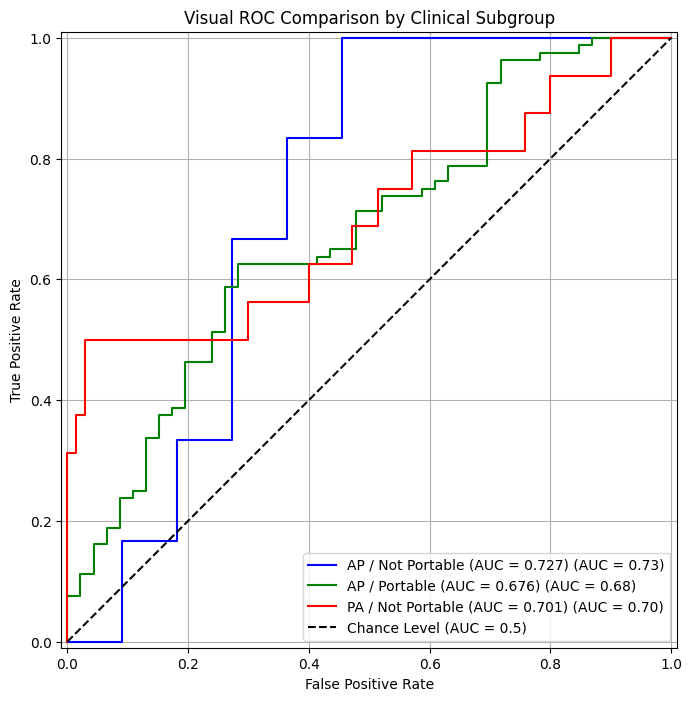

In [ ]:
# Display the detailed metrics table FIRST
results_df = pd.DataFrame(all_results)
print("\nQuantitative Performance by Clinical Subgroup")
display_cols = ['projection', 'is_portable', 'auc', 'f1', 'recall', 'precision', 'n_samples']
print(results_df[display_cols].round(4))

# Generate the visual ROC plot using the same data
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple'] # Add more colors if you have more groups

for i, result in enumerate(all_results):
    group_name = f"{result['projection']} / {'Portable' if result['is_portable'] else 'Not Portable'}"
    RocCurveDisplay.from_predictions(
        result['labels'],
        result['probs'],
        name=f"{group_name} (AUC = {result['auc']:.3f})",
        color=colors[i % len(colors)], # Cycle through colors
        ax=ax,
    )

ax.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Visual ROC Comparison by Clinical Subgroup")
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

The results from our subgroup evaluation confirm our hypothesis: the model's performance is not consistent across different clinical contexts.

Here have successfully identified a significant fairness and safety issue. The model's performance is biased by the clinical context in which the X-ray was taken. Now, our next task is to implement a mitigation strategy to address this disparity and retrain the model to be more equitable.

# Mitigation Strategy: Targeted Oversampling

Our analysis revealed that the model performs worst on the `PA / False subgroup`, which represents healthier, ambulatory patients. This is likely because the model was trained on data where this group had both fewer samples and a lower disease prevalence

Now our goal is to increase the representation of this underperforming group in our training data. By showing the model more examples of `PA / False scans` (both positive and negative cases), we think that it will learn to better distinguish the features specific to this context, improving its Precision and F1-score and closing the performance gap with the other groups.

In [ ]:
# Isolate the underperforming group from the original training dataframe
df_pa_false = train_df[(train_df['projection'] == 'PA') & (train_df['is_portable'] == False)]

# Isolate the rest of the data
df_others = train_df[~((train_df['projection'] == 'PA') & (train_df['is_portable'] == False))]

# Define an oversampling factor. A factor of 2 means we will double its presence.
oversample_factor = 2
n_samples_to_add = len(df_pa_false) * (oversample_factor - 1)

# Perform oversampling by sampling WITH REPLACEMENT from the isolated group
# This duplicates existing samples from the target group.
df_pa_false_oversampled = df_pa_false.sample(
    n=n_samples_to_add,
    replace=True,
    random_state=42
)

# Create the new, "fairer" training dataframe by combining the original data with the new samples
train_df_fairer = pd.concat([train_df, df_pa_false_oversampled])

# --- Verification ---
print("--- Comparing Group Counts Before and After Oversampling ---")
print("\nOriginal train_df counts:")
print(train_df.groupby(['projection', 'is_portable']).size())

print("\n------------------------------------")
print("New 'train_df_fairer' counts:")
print(train_df_fairer.groupby(['projection', 'is_portable']).size())

print(f"\nSuccessfully added {len(df_pa_false_oversampled)} samples to the 'PA / False' group.")

--- Comparing Group Counts Before and After Oversampling ---

Original train_df counts:
projection  is_portable
AP          False           27
            True           127
PA          False          114
            True             0
dtype: int64

------------------------------------
New 'train_df_fairer' counts:
projection  is_portable
AP          False           27
            True           127
PA          False          228
            True             0
dtype: int64

Successfully added 114 samples to the 'PA / False' group.


### Train fairer model

In [ ]:
train_dataset_cls = ClassificationDataset(
    train_df_fairer,
    f'{DATA_PATH}/files-png/',
    train = True
)

val_dataset_cls = ClassificationDataset(
    val_df,
    f'{DATA_PATH}/files-png/'
)

train_dataloader = DataLoader(train_dataset_cls, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset_cls, batch_size=32, shuffle=True)

Download the trained model

In [ ]:
!curl https://uni-bonn.sciebo.de/s/ywwRa3jryT8Epon/download/fairer-efficientnetb4-pathology-cxr2.pth --output fair-efficientnetb4-pathology-cxr2.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.6M  100 67.6M    0     0  13.6M      0  0:00:04  0:00:04 --:--:-- 15.2M


Download the model

In [ ]:
!curl https://uni-bonn.sciebo.de/s/sWrJoYTn2WjYoSN/download/fairer-efficientnetb4-pathology-cxr2.pth --output fair-efficientnetb4-pathology-cxr2.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.6M  100 67.6M    0     0  12.6M      0  0:00:05  0:00:05 --:--:-- 16.4M


In [ ]:
learning_rate = 3e-4
batch_size = 32
epochs = 20

model_cls = efficientnet_b4(weights=EfficientNet_B4_Weights)
model_cls.classifier[1] = nn.Sequential(
    # nn.Dropout(0.3),
    nn.Linear(1792, 2)
)

train_dataloader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_cls, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cls.parameters(), lr=learning_rate, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

model_cls.to(device)
loss_fn.to(device)

s = time.process_time()

best_acc = 0
best_model = None

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_cls = train_loop_cls(train_dataloader, model_cls, loss_fn, optimizer, device)
    lr_scheduler.step()
    test_acc = val_loop_cls(val_dataloader, model_cls, loss_fn, device)

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model_cls

print("Done!")

torch.save(best_model.state_dict(), './fair-efficientnetb4-pathology-cxr2.pth')

e = time.process_time() # end time
print(e - s, "seconds")

Epoch 1
-------------------------------
Train → Loss: 0.6881, Acc: 0.5497
 Val  → Loss: 0.6706, Acc: 0.5652

Epoch 2
-------------------------------
Train → Loss: 0.6560, Acc: 0.6728
 Val  → Loss: 0.6496, Acc: 0.5870

Epoch 3
-------------------------------
Train → Loss: 0.6041, Acc: 0.7330
 Val  → Loss: 0.6241, Acc: 0.6739

Epoch 4
-------------------------------
Train → Loss: 0.5210, Acc: 0.7435
 Val  → Loss: 0.6174, Acc: 0.6957

Epoch 5
-------------------------------
Train → Loss: 0.4468, Acc: 0.7827
 Val  → Loss: 0.5933, Acc: 0.6739

Epoch 6
-------------------------------
Train → Loss: 0.4220, Acc: 0.7880
 Val  → Loss: 0.5497, Acc: 0.7391

Epoch 7
-------------------------------
Train → Loss: 0.3607, Acc: 0.8325
 Val  → Loss: 0.5747, Acc: 0.7609

Epoch 8
-------------------------------
Train → Loss: 0.3035, Acc: 0.8639
 Val  → Loss: 0.5877, Acc: 0.7391

Epoch 9
-------------------------------
Train → Loss: 0.2579, Acc: 0.8979
 Val  → Loss: 0.6005, Acc: 0.7391

Epoch 10
----------

### Evaluate the newly trained model

In [ ]:
# Load the New "Fairer" Model

model_fairer = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
model_fairer.classifier[1] = nn.Sequential(nn.Linear(1792, 2))
model_fairer.load_state_dict(torch.load('./fair-efficientnetb4-pathology-cxr2.pth')) # Load model
model_fairer.eval()
model_fairer.to(device)


# Re-evaluate Performance on All Subgroups
print("Re-evaluating Performance with the 'Fairer' Model")
all_results_fairer = []
group_keys = test_df.groupby(['projection', 'is_portable']).groups.keys()

for proj, port in group_keys:
    print(f"Evaluating group: Projection='{proj}', Portable={port}")
    df_subgroup = test_df[(test_df['projection'] == proj) & (test_df['is_portable'] == port)]

    # Using the same evaluation function ensures a fair comparison
    metrics = evaluate_subgroup(model_fairer, df_subgroup, f'{DATA_PATH}/files/p18', device)

    if metrics:
        metrics['projection'] = proj
        metrics['is_portable'] = port
        all_results_fairer.append(metrics)

# Display and Compare Results
results_df_fairer = pd.DataFrame(all_results_fairer)

# Get the original results from the previous task for comparison
results_df_before = pd.DataFrame(all_results)

# Prepare data for comparison table
comparison_df = results_df_before[['projection', 'is_portable', 'auc', 'f1']].copy()
comparison_df.rename(columns={'auc': 'AUC Before', 'f1': 'F1 Before'}, inplace=True)
comparison_df = comparison_df.merge(
    results_df_fairer[['projection', 'is_portable', 'auc', 'f1']],
    on=['projection', 'is_portable']
)
comparison_df.rename(columns={'auc': 'AUC After', 'f1': 'F1 After'}, inplace=True)

print("\n--- Performance Comparison Before and After Mitigation ---")
print(comparison_df.round(4))

# Calculate the change in performance gap (e.g., between best and worst F1 score)
f1_gap_before = results_df_before['f1'].max() - results_df_before['f1'].min()
f1_gap_after = results_df_fairer['f1'].max() - results_df_fairer['f1'].min()

print(f"\nF1 Score Gap (Max - Min) Before Mitigation: {f1_gap_before:.4f}")
print(f"F1 Score Gap (Max - Min) After Mitigation:  {f1_gap_after:.4f}")

Re-evaluating Performance with the 'Fairer' Model
Evaluating group: Projection='AP', Portable=False
Evaluating group: Projection='AP', Portable=True
Evaluating group: Projection='PA', Portable=False

--- Performance Comparison Before and After Mitigation ---
  projection  is_portable  AUC Before  F1 Before  AUC After  F1 After
0         AP        False      0.7273     0.6154     0.5455    0.2222
1         AP         True      0.6755     0.7081     0.6720    0.6897
2         PA        False      0.7009     0.4706     0.7473    0.4516

F1 Score Gap (Max - Min) Before Mitigation: 0.2375
F1 Score Gap (Max - Min) After Mitigation:  0.4674


In [ ]:
# Load the New "Fairer" Model
model_fairer = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
model_fairer.classifier[1] = nn.Sequential(nn.Linear(1792, 2))
model_fairer.load_state_dict(torch.load('./fair-efficientnetb4-pathology-cxr2.pth')) # Load model
model_fairer.eval()
model_fairer.to(device)


# Re-evaluate Performance on All Subgroups
print("--- Re-evaluating Performance with the 'Fairer' Model ---")
all_results_fairer = []
group_keys = test_df.groupby(['projection', 'is_portable']).groups.keys()

for proj, port in group_keys:
    print(f"Evaluating group: Projection='{proj}', Portable={port}")
    df_subgroup = test_df[(test_df['projection'] == proj) & (test_df['is_portable'] == port)]

    # Using the same evaluation function ensures a fair comparison
    metrics = evaluate_subgroup(model_fairer, df_subgroup, f'{DATA_PATH}/files/p18', device) # Using the corrected function name

    if metrics:
        metrics['projection'] = proj
        metrics['is_portable'] = port
        all_results_fairer.append(metrics)

results_df_fairer = pd.DataFrame(all_results_fairer)
results_df_before = pd.DataFrame(all_results)

# Prepare data for comparison table
comparison_df = results_df_before[['projection', 'is_portable', 'auc', 'f1']].copy()
comparison_df.rename(columns={'auc': 'AUC Before', 'f1': 'F1 Before'}, inplace=True)
comparison_df = comparison_df.merge(
    results_df_fairer[['projection', 'is_portable', 'auc', 'f1']],
    on=['projection', 'is_portable']
)
comparison_df.rename(columns={'auc': 'AUC After', 'f1': 'F1 After'}, inplace=True)

print("\nPerformance Comparison Before and After Mitigation")
display(comparison_df.round(4))

auc_gap_before = results_df_before['auc'].max() - results_df_before['auc'].min()
auc_gap_after = results_df_fairer['auc'].max() - results_df_fairer['auc'].min()

print(f"\nAUC Gap (Max - Min) Before Mitigation: {auc_gap_before:.4f}")
print(f"AUC Gap (Max - Min) After Mitigation:  {auc_gap_after:.4f}")

--- Re-evaluating Performance with the 'Fairer' Model ---
Evaluating group: Projection='AP', Portable=False
Evaluating group: Projection='AP', Portable=True
Evaluating group: Projection='PA', Portable=False

Performance Comparison Before and After Mitigation


,projection,is_portable,AUC Before,F1 Before,AUC After,F1 After
0,AP,False,0.7273,0.6154,0.5455,0.2222
1,AP,True,0.6755,0.7081,0.6720,0.6897
2,PA,False,0.7009,0.4706,0.7473,0.4516



AUC Gap (Max - Min) Before Mitigation: 0.0517
AUC Gap (Max - Min) After Mitigation:  0.2019


Be aware that oversampling can cause overfitting: Simple oversampling works by duplicating existing samples. By massively increasing the presence of the `PA / False group`, we may cause the model to overfit to the specific examples in that duplicated set.

# Mitigation Strategy: Weighted Loss Function

The concept here is that instead of changing the data distribution, we will change how the model learns from the data. During training, we will make mistakes on the underperforming `PA / False` group more "expensive" or impactful. By assigning a higher weight to the loss calculated from these samples, we force the optimizer to prioritize learning their features correctly.

We will assign a higher weight to samples from our target underperforming group. The other groups will have a standard weight of 1.0.

A common starting point is a weight that is inversely proportional to the group's size.

In [ ]:
group_counts = train_df.groupby(['projection', 'is_portable']).size()
target_group_count = group_counts.loc[('PA', False)]

target_weight = 2.0
default_weight = 1.0

In [ ]:
#Create a 'weights' column in the training dataframe
# This makes it easy to retrieve the weight for each sample in our Dataset class.

# Create a boolean mask to identify the rows belonging to the target group
is_target_group = (train_df['projection'] == 'PA') & (train_df['is_portable'] == False)

# Assign weights based on the mask
train_df['sample_weight'] = np.where(is_target_group, target_weight, default_weight)

print("Sample of assigned weights")
print(train_df[['projection', 'is_portable', 'sample_weight']].head())
print("\nDistribution of assigned weights:")
print(train_df['sample_weight'].value_counts())

Sample of assigned weights
  projection  is_portable  sample_weight
0         PA        False            2.0
1         PA        False            2.0
2         PA        False            2.0
3         PA        False            2.0
4         PA        False            2.0

Distribution of assigned weights:
sample_weight
1.0    154
2.0    114
Name: count, dtype: int64


To use these weights, the training functions need a few modifications. Passing the dataframe weights to our `ClassificationDataset` and two loss functions for each case.

In [ ]:
#@title Helpers
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from PIL import ImageOps
class ClassificationDataset(Dataset):
    def __init__(self, dataframe, image_dir=None, train=False, image_size=380, channels=3):
        super().__init__()
        self.image_paths = dataframe['img_path'].tolist()
        self.labels      = dataframe['pathology'].tolist()

        # This assumes your dataframe has a 'sample_weight' column
        if 'sample_weight' in dataframe.columns:
            self.weights = dataframe['sample_weight'].tolist()
        else:
            # If no weights are provided (like for the validation set), default to 1.0
            self.weights = [1.0] * len(dataframe)


        self.size = image_size
        if channels== 3:
          self.mean = np.array([0.485, 0.456, 0.406])
          self.std  = np.array([0.229, 0.224, 0.225])
        elif channels==1:
          self.mean = np.array([0.5])
          self.std  = np.array([0.2])

      #  # build transforms
        if train:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.RandomRotation(degrees=(-20, 20)),
                torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
                torchvision.transforms.RandomResizedCrop(self.size, scale=(0.4, 0.6),ratio=(1.0, 1.0)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std),
            ])
        else:
            self.transforms_img = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=channels),
                torchvision.transforms.Resize((512, 512)),
                torchvision.transforms.CenterCrop((self.size, self.size)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(self.mean,self.std)
            ])

    def __getitem__(self, index: int):
        path   = self.image_paths[index]
        image  = Image.open(path).convert('L')
        image = self.transforms_img(image)
        target = torch.tensor(self.labels[index], dtype=torch.long)

        # Retrieve the weights
        weight = self.weights[index]
        weight = torch.tensor(weight, dtype=torch.float32)
        return image, target, weight

    def __len__(self) -> int:
        return len(self.image_paths)

def train_loop_cls(dataloader, model, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X, y, weights in dataloader:
        X, y, weights = X.to(device), y.to(device), weights.to(device)

        optimizer.zero_grad()
        logits = model(X)

        loss_unreduced = loss_fn(logits, y)
        loss = (loss_unreduced * weights).mean() # Weighted loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == y).sum().item()
        running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f"Train → Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    return model


def val_loop_cls(dataloader, model, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y, _ in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == y).sum().item()
            running_total += y.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f" Val  → Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}\n")
    # return epoch_loss, epoch_acc
    return epoch_acc

train_dataset_cls = ClassificationDataset(
    train_df,
    f'{DATA_PATH}/files-png/',
    train = True
)

val_dataset_cls = ClassificationDataset(
    val_df,
    f'{DATA_PATH}/files-png/'
)

train_dataloader = DataLoader(train_dataset_cls, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset_cls, batch_size=32, shuffle=True)

In [ ]:
learning_rate = 3e-4
batch_size = 32
epochs = 20

model_fairer_weighted = efficientnet_b4(weights=EfficientNet_B4_Weights)
model_fairer_weighted.classifier[1] = nn.Sequential(
    # nn.Dropout(0.3),
    nn.Linear(1792, 2)
)
model_fairer_weighted

train_dataloader = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_cls, batch_size=batch_size)

#wrapper loss for trianing
loss_fn = nn.CrossEntropyLoss(reduction='none') # we set redunction to 'none' to apply our weights
#wrapper loss for validation
loss_fn_val = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_fairer_weighted.parameters(), lr=learning_rate, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

model_fairer_weighted.to(device)
loss_fn.to(device)

s = time.process_time()

best_acc = 0
best_model = None

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_fairer_weighted = train_loop_cls(train_dataloader, model_fairer_weighted, loss_fn, optimizer, device)
    lr_scheduler.step()
    test_acc = val_loop_cls(val_dataloader, model_fairer_weighted, loss_fn_val, device)

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model_cls
        torch.save(best_model.state_dict(), './fair-weights-efficientnetb4-pathology-cxr2.pth')

print("Done!")

e = time.process_time() # end time
print(e - s, "seconds")

Epoch 1
-------------------------------
Train → Loss: 0.9734, Acc: 0.5597
 Val  → Loss: 0.6827, Acc: 0.5870

Epoch 2
-------------------------------
Train → Loss: 0.9346, Acc: 0.6567
 Val  → Loss: 0.6641, Acc: 0.5652

Epoch 3
-------------------------------
Train → Loss: 0.8961, Acc: 0.6716
 Val  → Loss: 0.6595, Acc: 0.5652

Epoch 4
-------------------------------
Train → Loss: 0.8022, Acc: 0.7388
 Val  → Loss: 0.6567, Acc: 0.5870

Epoch 5
-------------------------------
Train → Loss: 0.7687, Acc: 0.7388
 Val  → Loss: 0.6552, Acc: 0.6087

Epoch 6
-------------------------------
Train → Loss: 0.6720, Acc: 0.7500
 Val  → Loss: 0.6366, Acc: 0.6304

Epoch 7
-------------------------------
Train → Loss: 0.6445, Acc: 0.7836
 Val  → Loss: 0.6358, Acc: 0.6957

Epoch 8
-------------------------------
Train → Loss: 0.6248, Acc: 0.8060
 Val  → Loss: 0.6435, Acc: 0.6957

Epoch 9
-------------------------------
Train → Loss: 0.5360, Acc: 0.8209
 Val  → Loss: 0.6657, Acc: 0.7609

Epoch 10
----------

In [ ]:
#@title helper

def evaluate_subgroup(model, df_subgroup, image_dir, device):
    """
    Evaluates a subgroup and returns a dictionary with all key metrics
    and the raw data needed for ROC plotting.
    """
    if len(df_subgroup) == 0:
        return None # Return None if subgroup is empty

    dataset = ClassificationDataset(df_subgroup, image_dir, train=False)
    loader = DataLoader(dataset, batch_size=16)

    probs_list, preds_list, label_list = [], [], []

    with torch.no_grad():
        for X, y, _ in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            probs = nn.functional.softmax(out, dim=1)
            preds = probs.argmax(dim=1)

            probs_list.extend(probs[:, 1].cpu().numpy())
            preds_list.extend(preds.cpu().numpy())
            label_list.extend(y.cpu().numpy())

    # Calculate all metrics, handling edge cases for small groups
    if len(np.unique(label_list)) < 2: # Cannot compute AUC with only one class
        return None

    return {
        'accuracy': accuracy_score(label_list, preds_list),
        'f1': f1_score(label_list, preds_list, zero_division=0),
        'recall': recall_score(label_list, preds_list, zero_division=0),
        'precision': precision_score(label_list, preds_list, zero_division=0),
        'auc': roc_auc_score(label_list, probs_list),
        'labels': label_list,
        'probs': probs_list,
        'n_samples': len(label_list)
    }

In [ ]:
# model_fairer_weighted = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
# model_fairer_weighted.classifier[1] = nn.Sequential(nn.Linear(1792, 2))
# model_fairer_weighted.load_state_dict(torch.load('./fair-weights-efficientnetb4-pathology-cxr2.pth')) # Hypothetical path
model_fairer_weighted.eval()
model_fairer_weighted.to(device)

# Re-evaluate Performance on All Subgroups
print("--- Re-evaluating Performance with the Weighted Loss Model ---")
all_results_fairer = []
group_keys = test_df.groupby(['projection', 'is_portable']).groups.keys()

for proj, port in group_keys:
    print(f"Evaluating group: Projection='{proj}', Portable={port}")
    df_subgroup = test_df[(test_df['projection'] == proj) & (test_df['is_portable'] == port)]

    # Using our comprehensive evaluation function
    metrics = evaluate_subgroup(model_fairer_weighted, df_subgroup, f'{DATA_PATH}/files/p18', device)

    if metrics:
        metrics['projection'] = proj
        metrics['is_portable'] = port
        all_results_fairer.append(metrics)

# Display and Compare Results
results_df_fairer = pd.DataFrame(all_results_fairer)

# Get the original results from the first evaluation for comparison
results_df_before = pd.DataFrame(all_results)

# Prepare data for comparison table
comparison_df = results_df_before[['projection', 'is_portable', 'auc', 'f1']].copy()
comparison_df.rename(columns={'auc': 'AUC Before', 'f1': 'F1 Before'}, inplace=True)
comparison_df = comparison_df.merge(
    results_df_fairer[['projection', 'is_portable', 'auc', 'f1']],
    on=['projection', 'is_portable']
)
comparison_df.rename(columns={'auc': 'AUC After', 'f1': 'F1 After'}, inplace=True)

print("\n--- Performance Comparison Before and After Weighted Loss Mitigation ---")
print(comparison_df.round(4))

# Calculate the change in performance gap (e.g., between best and worst F1 score)
f1_gap_before = results_df_before['f1'].max() - results_df_before['f1'].min()
f1_gap_after = results_df_fairer['f1'].max() - results_df_fairer['f1'].min()

print(f"\nF1 Score Gap (Max - Min) Before Mitigation: {f1_gap_before:.4f}")
print(f"F1 Score Gap (Max - Min) After Mitigation:  {f1_gap_after:.4f}")

--- Re-evaluating Performance with the Weighted Loss Model ---
Evaluating group: Projection='AP', Portable=False
Evaluating group: Projection='AP', Portable=True
Evaluating group: Projection='PA', Portable=False

--- Performance Comparison Before and After Weighted Loss Mitigation ---
  projection  is_portable  AUC Before  F1 Before  AUC After  F1 After
0         AP        False      0.7273     0.6154     0.7879    0.7143
1         AP         True      0.6755     0.7081     0.7076    0.7805
2         PA        False      0.6991     0.4706     0.6625    0.3500

F1 Score Gap (Max - Min) Before Mitigation: 0.2375
F1 Score Gap (Max - Min) After Mitigation:  0.4305


Analyze the results and try different weights to improve the model fairness

## Visualize model predictions

Bring the differente trained models and compare them qualitatively

In [ ]:
# model_fairer_weighted = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
# model_fairer_weighted.classifier[1] = nn.Sequential(nn.Linear(1792, 2))
# model_fairer_weighted.load_state_dict(torch.load('./efficientnetb4-weighted.pth'))
model_fairer_weighted.eval()
model_fairer_weighted.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
#@title helper functions
import torch.nn as nn

def get_last_conv(model):
    last_name, last_conv = None, None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_name, last_conv = name, module
    return last_name, last_conv

#@title Utility functions
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(
    original_images: torch.Tensor,  # (N, C, H, W)
    heatmaps:         np.ndarray,    # (N, H_cam, W_cam)
    true_labels:      np.ndarray,    # (N,)
    num_to_show:      int = 5,
    mean:             float|list|tuple = 0.5,
    std:              float|list|tuple = 0.2
):
    """
    - original_images: Tensor(N, C, H, W), normalized via (x-mean)/std
    - heatmaps:        ndarray(N, H_cam, W_cam) in [0,1]
    - true_labels:     ndarray(N,)
    """
    N = min(num_to_show, original_images.shape[0])

    # prepare mean/std arrays for un-normalization
    if isinstance(mean, (list, tuple, np.ndarray)):
        mean_arr = np.array(mean)[:, None, None]
        std_arr  = np.array(std)[:,  None, None]
    else:
        mean_arr = mean
        std_arr  = std

    for i in range(N):
        # 1) pull & un-normalize the i-th image
        img = original_images[i].cpu().numpy()          # (C, H, W)
        img = img * std_arr + mean_arr                  # broadcast over C,H,W
        img = np.clip(img, 0, 1)

        # 2) convert to H×W×C for plotting
        img_hwc = np.transpose(img, (1, 2, 0))         # (H, W, C)
        H, W, _ = img_hwc.shape

        # 3) resize heatmap to match image size
        hm = heatmaps[i]                                # (H_cam, W_cam)
        hm_resized = cv2.resize(hm, (W, H), interpolation=cv2.INTER_LINEAR)

        # 4) overlay CAM
        cam_overlay = show_cam_on_image(img_hwc, hm_resized, use_rgb=True)

        # 5) plot side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(img_hwc)
        ax1.set_title(f"Original (Label: {true_labels[i]})")
        ax1.axis('off')

        ax2.imshow(cam_overlay)
        ax2.set_title("GradCAM Overlay")
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

lets capture the last layer, you can change this in the helper function

In [ ]:
name, target_layer = get_last_conv(model_fairer_weighted)

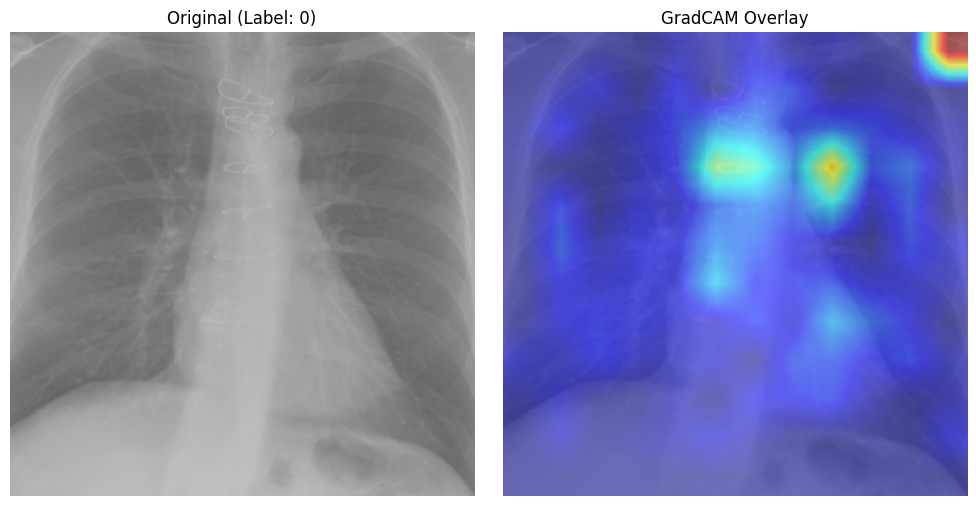

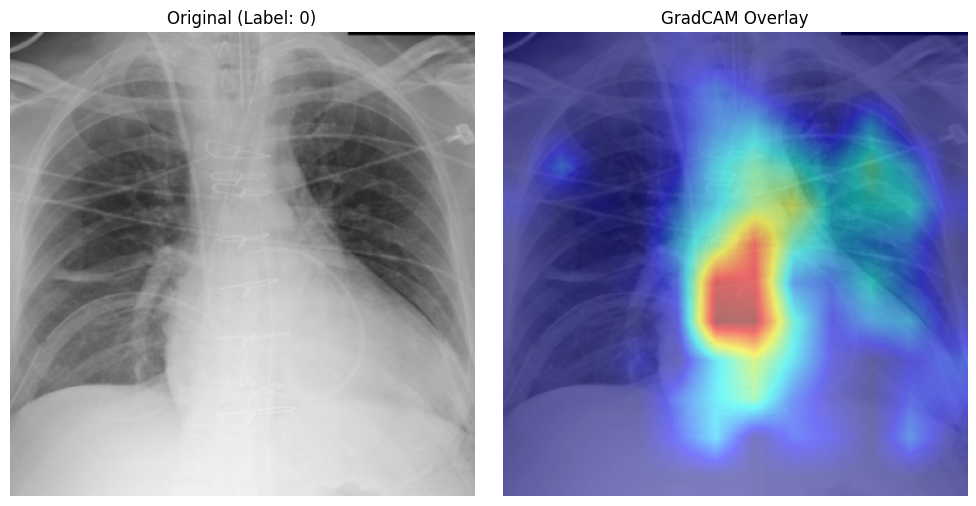

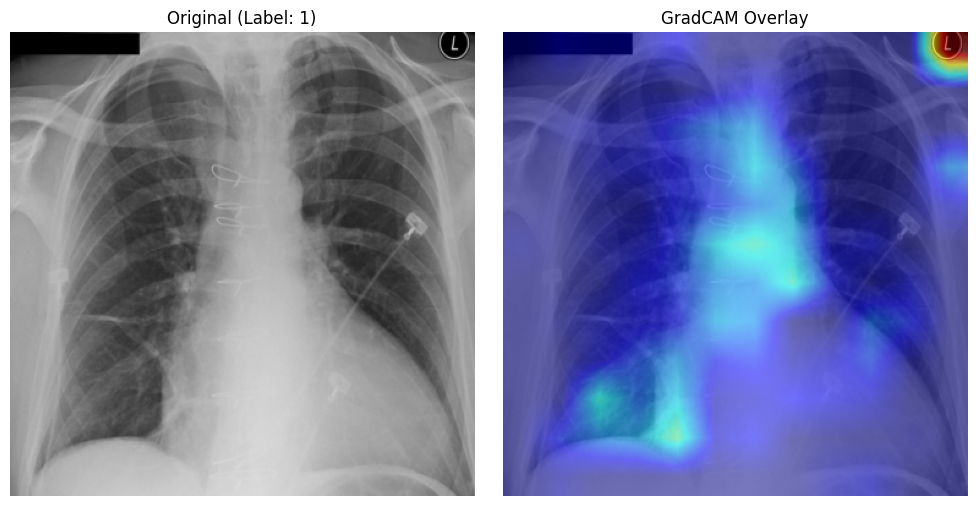

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus

N = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_fairer_weighted.to(device).eval()

test_dataset_cls = ClassificationDataset(
    test_df,
    f'{DATA_PATH}/files-png/'
)
test_dataloader = DataLoader(test_dataset_cls, batch_size=batch_size)


cam = GradCAMPlusPlus(model=model_fairer_weighted, target_layers=[target_layer])

heatmaps    = []
orig_images = []
true_labels = []

for inputs, labels, _ in test_dataloader:
    inputs = inputs.to(device)

    hm_batch = cam(input_tensor=inputs)
    heatmaps.extend(hm_batch)

    orig_images.extend(inputs.cpu())
    true_labels.extend(labels.numpy())

orig_images = torch.stack(orig_images, dim=0)
heatmaps    = np.stack(heatmaps,    axis=0)
true_labels = np.array(true_labels, dtype=int)


mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

visualize_gradcam(
    original_images=orig_images,
    heatmaps=heatmaps,
    true_labels=true_labels,
    num_to_show=N,
    mean=mean,
    std=std
)

This work highlights a critical lesson in medical AI: **an accurate model is not necessarily a fair or safe one**. A model that performs exceptionally well on average but fails on a specific, vulnerable patient population is not ready for clinical deployment. Fairness analysis is not merely an academic exercise; it is a crucial component of responsible model development and validation.


By using metadata to define and analyze performance across meaningful subgroups, we can build more robust, equitable, and ultimately more trustworthy AI tools that serve all patient populations effectively. The process of identifying bias, implementing a targeted mitigation strategy, and re-evaluating for improvement is a fundamental cycle in the development of clinical-grade artificial intelligence.